In [1]:
import numpy as np
import pandas as pd
from BenchmarkDataset import *
from animate_path import animate_path
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from TKM import TKM
from perform_clustering import read_data, perform_clustering, k_means, dbscan
import os
from sklearn.metrics.cluster import adjusted_mutual_info_score


In [2]:
from st_clustering import *

In [3]:
df = pd.read_csv('full_data/couzin_100_60.csv')
df['x'] = (df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min())
df['y'] = (df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min())


frame_positions = []

for frame in df['frame'].unique():
    frame_data = df[df['frame'] == frame]

    n_id = frame_data['id'].nunique()

    frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()

    frame_data.sort_values(["id_cumcounts", "id"], inplace=True)

    frame_positions.append(frame_data[['frame', 'x', 'y']].to_numpy()[:n_id])

# # transform to numpy array


st_data = np.array(frame_positions)
t,n, m_plus = st_data.shape
st_data = st_data.reshape(t*n, m_plus)

true_labels = frame_data['cid'].to_list()[:n_id]
full_labels = np.tile(true_labels, t)

FRAME_SIZE = 100
FRAME_OVERLAP = 10

k = len(np.unique(full_labels))


# if -1 in np.unique(labels):
#         n_cluster = len(np.unique(labels)) - 1
# else:
#     n_cluster = len(np.unique(labels))

# param_dict_kmeans = {'eps2':[5, 25, 50, 100], 'n_clusters': [n_cluster]}
# opt_param_kmeans = st_grid_search(estimator=ST_KMeans, split=True, X=data, param_dict=param_dict_kmeans, metric='ami', y=labels, frame_size=FRAME_SIZE, frame_overlap=FRAME_OVERLAP)
# print(opt_param_kmeans)

kmeans = ST_KMeans(n_clusters = k, eps2 = 50)
kmeans.st_fit_frame_split(st_data, FRAME_SIZE, FRAME_OVERLAP)



/var/folders/xz/_nh5vnzd6w35js_89b99q6r40000gn/T/ipykernel_24362/448276275.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


ST_KMeans(eps2=50)

In [142]:
# param_dict_agglo = {'eps2':[5, 25, 50, 100], 'n_clusters': [k]}
opt_param_agglo = {'eps2':100, 'n_clusters': k}

agglo = ST_Agglomerative(**opt_param_agglo)
agglo.st_fit_frame_split(st_data, FRAME_SIZE, FRAME_OVERLAP)



ST_Agglomerative(eps2=100, n_clusters=8)

In [76]:
from st_dbscan import ST_DBSCAN

st_dbscan = ST_DBSCAN(eps1 = 0.02, eps2 = 10, min_samples = 2)
st_dbscan.fit(st_data)

In [144]:
adjusted_mutual_info_score(full_labels, agglo.labels)
print(ami)

weights_db = agglo.labels.reshape((t,n)).T
sim_mat = similarity_matrix(weights_db)

# ltc = find_k_clusters(k=k, criteria_mat=sim_mat, verbose = True)
ltc = find_long_term_clusters(similarity_threshold = 0.70, criteria_mat= sim_mat)

print(k, ltc)

pred_labels = np.zeros(n)

for i, cluster in enumerate(ltc):
    pred_labels[cluster] = i
    
adjusted_mutual_info_score(true_labels, pred_labels)

0.8460548678752023
8 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 11], [17, 18, 19], [20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 24, 32, 33, 35, 36], [31], [34], [37], [38], [39], [40], [41, 48], [42, 43, 46], [44], [45], [47], [49], [50], [51], [52], [53], [54]]


0.6520916352927406

In [159]:
animate_path(tkm_data, st_dbscan.labels.reshape((t,n)).T, anim_frames = t, anim_interval = 100)


ValueError: cannot reshape array of size 5600 into shape (100,55)

2022-01-31 16:48:28,566 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


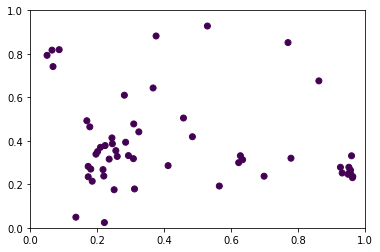

In [173]:
animate_path(tkm_data, kmeans.labels.reshape((t,n)).T, anim_frames = t, anim_interval = 100)

In [ ]:
#Create one file that stores all of the filenames, ami, and tot_ami
#Create a second file that only stores the average ami and average total ami for various sized datasets

In [7]:
ami_list = []
tot_ami_list = []
runtime_list = []

# sizes = [800, 3000, 6000, 10000, 15000, 20000, 25000, 35000, 50000, 80000, 100000, 130000, 150000, 180000, 200000]

# for ind in range(len(sizes) -1):
#     min_size = sizes[ind]
#     max_size = sizes[ind+1]

min_size = 6000
max_size = 10000

f = open("log_%d_%d.txt" %(min_size, max_size), "w")


for filename in os.listdir("full_data/"):
    if filename.endswith(".csv"):
        data, tkm_data, true_labels = read_data('full_data/'+filename, min_size = min_size, max_size = max_size)

        if tkm_data is not None:
            ami, tot_ami, runtime, weights = perform_clustering(tkm_data, true_labels, max_iter=5000)
            ami_list.append(ami)
            tot_ami_list.append(tot_ami)
            runtime_list.append(runtime)
            
            
#             f.write(filename, ' ami: ', ami, ' total_ami: ', tot_ami, '\n\n')
            f.write(filename + ' ami: %f total_ami: %f runtime: %f \n\n' %(ami, tot_ami, runtime))
            print('running average', np.average(ami_list), np.average(tot_ami_list), np.average(runtime_list), '\n')



    else:
        continue

ami_average = np.average(ami_list)
tot_ami_average = np.average(tot_ami_list)
runtime_average = np.average(runtime_list)

f.write('ami average: %f total ami average: %f average runtime: %f' %(ami_average, tot_ami_average, runtime_average))
f.close()

/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9480873914336307 0.9108345895592865 10.77483081817627 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9740436957168154 0.5082320152470757 10.705059885978699 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9826957971445435 0.34063751424929206 12.26417056719462 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9870218478584076 0.33949929783763394 13.434635877609253 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9896174782867261 0.37271223261765 12.918007469177246 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9872246354423191 0.39751478510222554 13.616670568784079 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9853748402490548 0.40478631436213447 13.389084509440831 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9738974214681798 0.46694012136821283 13.122182935476303 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Maximum number of iterations
running average 0.9730580487791252 0.4818485518677133 12.92208849059211 



/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


KeyboardInterrupt: 

In [37]:
#'full_data/reynolds_100_92.csv'
#'full_data/reynolds_100_78.csv'

data, tkm_data, true_labels = read_data('full_data/reynolds_100_78.csv', min_size = 0, max_size = 130000)

t,m,n = tkm_data.shape

/Users/olgadorabiala/Documents/Thesis/tkm/perform_clustering.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data["id_cumcounts"] = frame_data.groupby("id").cumcount()
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [90]:
data.head()

frame  id         x         y  cid
0      0   0  0.050921  0.533151    0
1      0   1  0.050650  0.346972    0
2      0   2  0.032072  0.396908    0
3      0   3  0.032544  0.266609    0
4      0   4  0.035692  0.342163    0

In [3]:
print(len(data), data['cid'].unique(), data['id'].nunique(), data['id'].nunique()*data['frame'].nunique())

2800 [0 1] 24 2400


2022-02-07 07:41:00,194 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


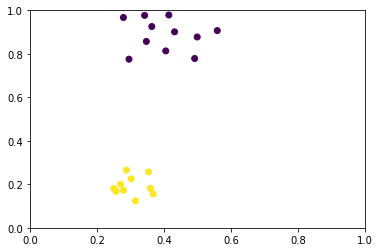

In [38]:
animate_path(tkm_data, np.tile(true_labels, t).reshape((t,n)).T, anim_frames = t, anim_interval = 100)

In [39]:
ami, tot_ami, runtime, weights = perform_clustering(tkm_data, true_labels)

print(ami, tot_ami)

1.0 0.999999999999999


In [40]:
k = data['cid'].nunique()
t,m,n = tkm_data.shape
tkm = TKM(tkm_data)
# tkm.perform_clustering_center_derivative(k=k, lam = .60, gamma =.10, max_iter = 5000)
tkm.perform_clustering(k=k, lam = .60, max_iter = 5000)
# tkm.perform_clustering_weight_constraint(k=k, lam = .60, max_iter = 5000)



# tkm.perform_clustering_constant_weights(k=k, lam = .60, max_iter = 5000)



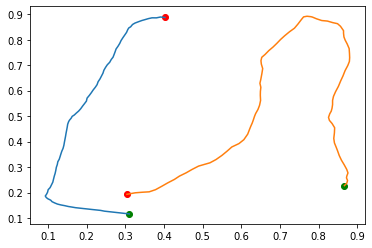

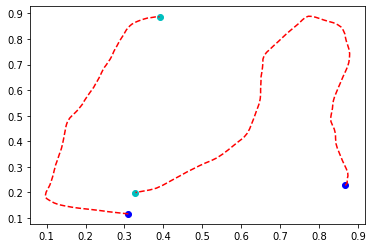

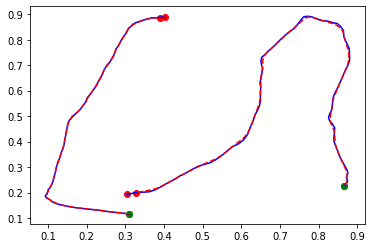

In [41]:
plt.figure()
for i in range(k):
    swarm_members = np.where(np.array(true_labels) == i)[0]
    swarm_mean = np.average(tkm_data[:,:, swarm_members], axis = 2)

    plt.scatter(swarm_mean[0,0], swarm_mean[0,1], c = 'g')
    plt.scatter(swarm_mean[-1,0], swarm_mean[-1,1], c = 'r')
    plt.plot(swarm_mean[:,0], swarm_mean[:,1], label = 'true')
    
plt.figure()
for j in range(k):
    plt.plot(tkm.centers[:, 0, j], tkm.centers[:,1,j], 'r--', label = 'predicted')
    plt.scatter(tkm.centers[0,0,j], tkm.centers[0,1,j], c = 'b')
    plt.scatter(tkm.centers[-1,0,j], tkm.centers[-1,1,j], c = 'c')
    
    
plt.figure()
for i in range(k):
    swarm_members = np.where(np.array(true_labels) == i)[0]
    swarm_mean = np.average(tkm_data[:,:, swarm_members], axis = 2)

    plt.scatter(swarm_mean[0,0], swarm_mean[0,1], c = 'g')
    plt.scatter(swarm_mean[-1,0], swarm_mean[-1,1], c = 'r')
    plt.plot(swarm_mean[:,0], swarm_mean[:,1], c = 'b', label = 'true')
    

for j in range(k):
    plt.plot(tkm.centers[:, 0, j], tkm.centers[:,1,j], 'r--', label = 'predicted')
    plt.scatter(tkm.centers[0,0,j], tkm.centers[0,1,j], c = 'g')
    plt.scatter(tkm.centers[-1,0,j], tkm.centers[-1,1,j], c = 'r')
    
    



In [99]:
from TKM_long_term_clusters import find_k_clusters, find_long_term_clusters, similarity_matrix

assignments = np.argmax(tkm.weights, axis = 2).T

sim_mat = similarity_matrix(assignments)

find_k_clusters(k=k, criteria_mat=sim_mat, threshold_change = .005, verbose=True)

ltc = find_long_term_clusters(similarity_threshold = .67, criteria_mat = sim_mat)
print(ltc)

Threshold for  2  clusters:  0.6799999999999999
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23], [14]]


In [100]:
pred_labels = np.zeros(n)

for i, cluster in enumerate(ltc):
    pred_labels[cluster] = i
    
# pred_labels = np.argmax(tkm.weights, axis = 1)

ami = adjusted_mutual_info_score(true_labels, pred_labels)

print(ami)

tot_ami = adjusted_mutual_info_score(np.tile(true_labels,t), (assignments.T).reshape(t*n) )

print(tot_ami)

-0.008292263623458382
0.11832288646896238


2022-02-01 12:51:45,040 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


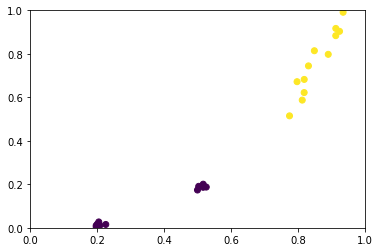

In [101]:
animate_path(tkm_data, assignments, anim_frames = t, anim_interval = 100)


In [ ]:
# ami over all time steps

adjusted_mutual_info_score(np.tile(true_labels, data['frame'].nunique()), (assignments.T).reshape(data['id'].nunique()*data['frame'].nunique()))



In [126]:
k

6